## Timing our algorithms

In [1]:
import time, random
import pandas as pd
import seaborn as sns
import matplotlib as plt
import sys

In [2]:
import parsers, helperpackage, SAIS

In [3]:
import search_bwd

In [4]:
def dna(length=int(), letters="CGTA"):
    return''.join(random.choices(letters, k=length))

def create_one_fasta(n):
    name = f"test_files/n_{n}.fasta"
    f = open(name, "w")

    f.write('>Seq' + str(1) + '\n' + dna(n) + '\n')

    f.close()

    return name

def create_many_fasta(start, stop, step):
    name = f"test_files/n_{stop}.fasta"
    f = open(name, "w")
    counter = 1

    for i in range(start, stop, step):
        f.write('>Seq' + str(counter) + '\n' + dna(i) + '\n')
        counter += 1
    f.close()

    return name

def create_one_fastq(m):
    name = f"test_files/m_{m}.fastq"
    f = open(name, "w")
    f.write(
        '@' + 'Seq' + str(1) + '\n' +
        dna(m) + '\n' +
        '+' + '\n' +
        '~' * m + '\n')
    f.close()

    return name

def create_many_fastq(start, stop, step):
    name = f"test_files/m_{stop}.fastq"
    f = open(name, "w")

    counter = 1

    for i in range(start, stop, step):
        f.write(
            '@' + 'Seq' + str(counter) + '\n' +
            dna(i) + '\n' +
            '+' + '\n' +
            '~' * i + '\n'
        )
        counter += 1

    f.close()

    return name



In [5]:
def time_construction(m, sa_dict, rsa_dict, fastq, o_dict, c_dict, ro_dict, max_edits):
    df = pd.DataFrame(range(20, m, int(m/10)), columns=['m'])
    times = []

    if len(sa_dict) < 0 or len(fastq) < 0:
        return "Problems with either fastq file or the SA"

    for x in sa_dict.items():
        rname = x[0]
        y = x[1][0]
        sa = x[1][1]
        rsa = rsa_dict[rname][1]

        O = o_dict[rname]
        C = c_dict[rname]
        RO = ro_dict[rname]
        alpha = {a: i for i, a in enumerate(sorted(set(y + '0')))}

        for p in fastq.items():
            qname = p[0]
            substring = p[1][0]
            qual = p[1][1]

            d = helperpackage.d_table(RO, C, rsa, substring, alpha) 
            start = time.time()
            search_bwd.bw_approx(O, C, substring, d, sa, alpha, max_edits, qname, rname, qual)
            stop = time.time()
            difference = stop - start
            times.append(difference)


    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['m']
    return df

In [6]:
n = 100000
m = 1000

In [7]:
sa_dict = helperpackage.read_SA("preprocessing/n_100000.fa.sa")
rsa_dict = helperpackage.read_SA("preprocessing/n_100000.fa.rev.sa")
o_dict = helperpackage.read_o("preprocessing/n_100000.fa.o-table")
c_dict = helperpackage.read_c("preprocessing/n_100000.fa.c-table")
ro_dict = helperpackage.read_o("preprocessing/n_100000.fa.ro-table")
fastq = helperpackage.read_fastq_file("test_files/m_1000.fq")

In [8]:
df_stc0 = time_construction(m, sa_dict, rsa_dict, fastq, o_dict, c_dict, ro_dict, 0)
df_stc1 = time_construction(m, sa_dict, rsa_dict, fastq, o_dict, c_dict, ro_dict, 1)
df_stc2 = time_construction(m, sa_dict, rsa_dict, fastq, o_dict, c_dict, ro_dict, 2)
df_stc5 = time_construction(m, sa_dict, rsa_dict, fastq, o_dict, c_dict, ro_dict, 5)

Seq1	0	Seq1	32661	0	13M1I6M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	32661	0	14M1I5M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90891	0	1M1I5M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90891	0	2M1I4M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90889	0	3M1D4M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90890	0	1I2M1D4M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90888	0	1M1D2M1D4M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90889	0	4M1D3M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90890	0	1I3M1D3M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90888	0	1M1D3M1D3M1I8M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90891	0	1M1I6M1I7M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0	Seq1	90891	0	2M1I5M1I7M1I3M	*	0	0	GAGTGAAGGTTTAGGTGGGG	~~~~~~~~~~~~~~~~~~~~
Seq1	0

In [14]:
concat = pd.concat([
    df_stc0.assign(edits='d = 0'), 
    df_stc1.assign(edits='d = 1'), 
    df_stc2.assign(edits='d = 2')], ignore_index = True)

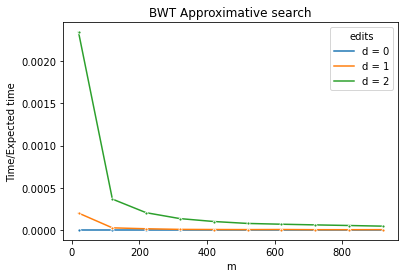

In [16]:
h = sns.lineplot(x = 'm', y = 'Time/Expected time', marker = '.',
                    hue = 'edits', data = concat)
h.set_title('BWT Approximative search')
h.figure.savefig('../figures/bwd_m.pdf')

In [ ]:
col_names = ["Program", "Sequence", "Read", "k", "m", "Time"]
readmapping_report = pd.read_table("readmapping-report.txt", sep=' ', names=col_names, index_col=False)

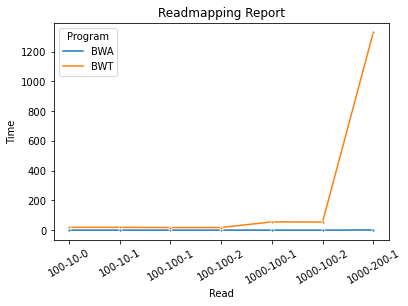

In [ ]:
h = sns.lineplot(x = 'Read', y = 'Time', marker = '.', hue="Program",
                    data = readmapping_report, ci=None, )
h.set_title('Readmapping Report')
h.tick_params(axis='x', rotation=30)
h.figure.savefig('../figures/Readmapping_Report.pdf')